In [1]:
import os
import csv
# 读取所有的model文件


model_to_model_file_path = 'data/model_dependency.csv'

model_set = set()

# Read the CSV file
with open(model_to_model_file_path, mode='r') as csv_file:
    csv_reader = csv.reader(csv_file)
    
    # Extract headers
    headers = next(csv_reader)
    print(f"Headers: {headers}\n")
    
    # Process each row
    for row in csv_reader:
        if row[3] != '2':
            # not a code model
            continue
        model_name = row[0]
        parent_name = row[1]
        model_set.add(model_name)
        model_set.add(parent_name)

print(f"Total number of code models: {len(model_set)}")

Headers: ['Model Name', 'Parent_Model', 'Type', 'Is code model', 'plausible', '']

Total number of models: 362


In [10]:
# 构建下载链接，将每个README.md按照model名字重命名使用wget下载
# link is like https://huggingface.co/segmind/SSD-1B/resolve/main/README.md

for model_name in model_set:
    if len(model_name) == 0:
        continue
    link = f"https://huggingface.co/{model_name}/resolve/main/README.md"
    file_name = model_name.replace('/', '--')
    os.system(f"wget -O readme/{file_name}.md {link}")
    print(f"Downloaded {file_name}.md")

Downloaded SEBIS--code_trans_t5_base_source_code_summarization_csharp.md
Downloaded DunnBC22--codet5-base-Generate_Docstrings_for_Python-Condensed.md
Downloaded pszemraj--bart-base-code-instructiongen.md
Downloaded Johannes--distilbert-base-uncased-finetuned-code-snippet-quality-scoring.md
Downloaded SEBIS--code_trans_t5_large_code_documentation_generation_go_multitask.md
Downloaded TabbyML--SantaCoder-1B.md
Downloaded SEBIS--code_trans_t5_small_source_code_summarization_csharp_multitask_finetune.md
Downloaded SIC98--GPT2-python-code-generator.md
Downloaded SEBIS--code_trans_t5_large_code_comment_generation_java_multitask_finetune.md
Downloaded mamiksik--CodeBertaCLM.md
Downloaded SEBIS--code_trans_t5_small_program_synthese.md
Downloaded SEBIS--code_trans_t5_base_code_documentation_generation_python_multitask.md
Downloaded SEBIS--code_trans_t5_base_code_documentation_generation_python_multitask_finetune.md
Downloaded SEBIS--code_trans_t5_small_commit_generation_multitask.md
Downloaded 

In [11]:
# Now analyze each file

# 有一些可以分析的问题
'''
1. 是否使用了model card的information. 这里其实可以认为是practice. spaces不是主动的practice. 但是widget是.
2. model card中存在什么内容，使用的情况如何？
3. 是否使用了Gated fields.
4. documentation中存在哪些内容？inline code, tables, images, external links, code blocks, lists.
'''

'\n1. 是否使用了model card的information\n2. model card中存在什么内容，使用的情况如何？\n3. 是否使用了Gated fields.\n4. documentation中存在哪些内容？inline code, tables, images, external links, code blocks, lists.\n'

In [12]:
# get card and doc

def get_card_and_doc(file_path):
    '''given the path to the readme file,
    return the model card and documentation part'''
    with open(file_path, 'r') as f:
        lines = f.readlines()
        card = []
        doc = []
        flag_count = 0
        for line in lines:
            if line.startswith('---'):
                flag_count += 1
                continue
            if flag_count == 1:
                card.append(line)
            else:
                doc.append(line)
    
    return ''.join(card), ''.join(doc)

doc_path = './readme'

# iterate through all the files in the directory
cards = []
docs = []
for filename in os.listdir(doc_path):
    file_path = os.path.join(doc_path, filename)
    card, doc = get_card_and_doc(file_path)
    cards.append(card)
    docs.append(doc)


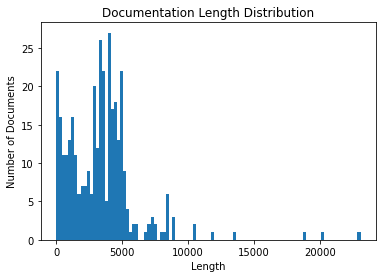

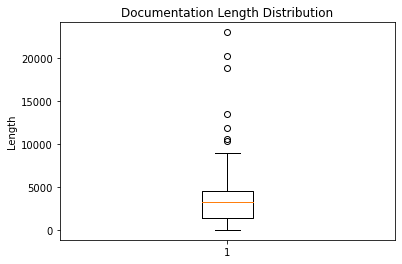

In [13]:
# Analyze the documentation first.

# length distribution
# draw a histogram

import matplotlib.pyplot as plt
import numpy as np

doc_lengths = [len(doc) for doc in docs]
plt.hist(doc_lengths, bins=100)
plt.title('Documentation Length Distribution')
plt.xlabel('Length')
plt.ylabel('Number of Documents')
plt.show()

# draw a boxplot
plt.boxplot(doc_lengths)
plt.title('Documentation Length Distribution')
plt.ylabel('Length')
plt.show()

# To-Do: 我们可以对比一下EMSE那篇收集到的在Github上AI相关的repository的documentation的长度分布

In [14]:
# analyze what's inside the documentation
# We consider: lists, code blocks, inline code, images, tables, and external links.
# write regular expressions to match them

import re

# Assuming 'docs' is a list of strings representing the contents of readme files
list_count = 0

# This pattern matches a list marker that's either at the start of the document
# or is not directly after another list item
list_start_pattern = re.compile(r'(?:^|\n)(?!\s*[-*]\s*\n)\s*[-*]\s')

for doc in docs:
    # Normalize line endings to Unix style for consistency
    doc = doc.replace('\r\n', '\n').replace('\r', '\n')

    # Find all matches for list starts
    list_starts = list_start_pattern.findall(doc)

    list_count += len(list_starts)

print(f"Total number of lists: {list_count}")
# print average
print(f"Average number of lists: {list_count / len(docs)}")

Total number of lists: 1362
Average number of lists: 3.772853185595568


In [16]:
# Assuming 'docs' is a list of strings representing the contents of readme files
code_block_pattern = re.compile(r'```')  # Pattern to match the start or end of a code block
code_block_count = 0

for doc in docs:
    # Find all occurrences of the code block pattern and divide by 2 since each block has a start and end
    code_block_count += len(code_block_pattern.findall(doc)) // 2

print(f"Total number of code blocks: {code_block_count}")
# print average
print(f"Average number of code blocks: {code_block_count / len(docs)}")

Total number of code blocks: 454
Average number of code blocks: 1.257617728531856


In [17]:
# inline code
inline_code_pattern = re.compile(r'`')
inline_code_count = 0
for doc in docs:
    inline_code_count += len(inline_code_pattern.findall(doc)) 
print(f"Total number of inline code: {inline_code_count}")
# print average
print(f"Average number of inline code: {inline_code_count / len(docs)}")

Total number of inline code: 3983
Average number of inline code: 11.033240997229917


In [18]:
# Assuming 'docs' is a list of strings representing the contents of readme files
table_count = 0
table_pattern = re.compile(r'(\|.+?\|)')  # Look for a sequence of the '|' character surrounded by other text

for doc in docs:
    # Find all potential table rows
    potential_table_rows = table_pattern.findall(doc)
    # Filter out rows that are just bold syntax or other non-table uses of '|'
    table_rows = [row for row in potential_table_rows if row.count('|') > 1]
    # Now we need to find consecutive rows, since a Markdown table consists of at least two consecutive rows of cells
    current_table_lines = 0
    for i in range(1, len(table_rows)):
        if table_rows[i-1].count('|') == table_rows[i].count('|'):
            # We have a consecutive row, so we increment our current table line count
            current_table_lines += 1
        else:
            # If the line counts do not match, we're not in a table anymore
            if current_table_lines > 0:
                # We had a table, so we count it and reset the line count
                table_count += 1
                current_table_lines = 0
    # Check if the last line was part of a table
    if current_table_lines > 0:
        table_count += 1

print(f"Total number of tables: {table_count}")
# print average
print(f"Average number of tables: {table_count / len(docs)}")


Total number of tables: 200
Average number of tables: 0.554016620498615


In [19]:

# Assuming 'docs' is a list of strings representing the contents of readme files
# This pattern is looking for Markdown image syntax with common image file extensions
image_pattern = re.compile(r'!\[.*?\]\((.*?\.(?:png|jpe?g|gif|bmp|svg))(?:\s*".*?")?\)', re.IGNORECASE)
image_count = 0

for doc in docs:
    # Find all matches for image syntax with a proper image file extension
    images = image_pattern.findall(doc)
    image_count += len(images)

print(f"Total number of images: {image_count}")
# print average
print(f"Average number of images: {image_count / len(docs)}")


Total number of images: 24
Average number of images: 0.0664819944598338


In [20]:
import re

# Assuming 'docs' is a list of strings representing the contents of readme files
# This pattern is a basic URL pattern and might need to be extended based on the actual contents
url_pattern = re.compile(r'https?://\S+')
url_count = 0

for doc in docs:
    # Find all matches for URLs
    urls = url_pattern.findall(doc)
    url_count += len(urls)

print(f"Total number of URLs: {url_count}")
# print average
print(f"Average number of URLs: {url_count / len(docs)}")


Total number of URLs: 2133
Average number of URLs: 5.908587257617729


In [25]:
# count the number of cards that are empty
empty_card_count = 0
for card in cards:
    if len(card) == 0:
        empty_card_count += 1
print(f"Total number of empty cards: {empty_card_count}")
# print ratio
print(f"Ratio of empty cards: {empty_card_count / len(cards)}")

Total number of empty cards: 40
Ratio of empty cards: 0.11080332409972299


In [27]:
# Analyze what is inside the model card

data_name_to_count = {}

for card in cards:
    card_lines = card.split('\n')
    for line in card_lines:
        if line.startswith('- ') or line.startswith(' ') or len(line) == 0:
            continue
        else:
            data_name = line.split(':')[0]
            if data_name not in data_name_to_count:
                data_name_to_count[data_name] = 1
            else:
                data_name_to_count[data_name] += 1

data_name_to_count

# rank the data names
import operator
sorted_data_name_to_count = sorted(data_name_to_count.items(), key=operator.itemgetter(1), reverse=True)
sorted_data_name_to_count

[('tags', 247),
 ('widget', 169),
 ('license', 153),
 ('datasets', 68),
 ('language', 66),
 ('model-index', 57),
 ('pipeline_tag', 36),
 ('metrics', 31),
 ('inference', 17),
 ('library_name', 17),
 ('extra_gated_prompt', 7),
 ('extra_gated_fields', 7),
 ('programming_language', 5),
 ('co2_eq_emissions', 4),
 ('thumbnail', 4),
 ('base_model', 2),
 ('task_categories', 1)]

In [30]:
# analyze license

license_to_count = {}

for card in cards:
    card_lines = card.split('\n')
    for line in card_lines:
        if line.startswith('license'):
            license_name = line.split(':')[1]
            if license_name not in license_to_count:
                license_to_count[license_name] = 1
            else:
                license_to_count[license_name] += 1


# rank
import operator
sorted_license_to_count = sorted(license_to_count.items(), key=operator.itemgetter(1), reverse=True)

# compute total number
total_license_count = 0
for license_name, count in sorted_license_to_count:
    total_license_count += count
print(f"Total number of licenses: {total_license_count}")
sorted_license_to_count

Total number of licenses: 153


[(' apache-2.0', 47),
 (' bsd-3-clause', 45),
 (' bigcode-openrail-m', 24),
 (' mit', 13),
 (' openrail', 7),
 (' "mit"', 3),
 (' agpl-3.0', 2),
 (' bigscience-bloom-rail-1.0', 2),
 (' "cc-by-nc-4.0"', 2),
 ('', 2),
 (' "apache-2.0"', 2),
 (' cc-by-sa-4.0', 1),
 (' cc-by-4.0', 1),
 (' bsd-2-clause', 1),
 (' wtfpl', 1)]

gate, inference，可以直接在这里考虑practice好了.

In [ ]:
# 分析license的count. license的分布，解释license的含义.

In [57]:
# Analyze the documentation in "What makes a popular academic AI repository?" paper

# get repository names

base_path = 'academic-ai-repos/code_repos'

repo_names = []
for username in os.listdir(base_path):
    if username == '.DS_Store':
        continue
    user_path = os.path.join(base_path, username)
    for repo_name in os.listdir(user_path):
        if repo_name == '.DS_Store':
            continue
        user_and_repo_name = f"{username}/{repo_name}"
        repo_names.append(user_and_repo_name)

# download their readme files to 'github_readme' folder
# the url format is https://github.com/{user_and_repo_name}/raw/master/README.md

for repo_name in repo_names:
    url = f"https://github.com/{repo_name}/raw/master/README.md"
    file_name = repo_name.replace('/', '--')
    os.system(f"wget -O github_readme/{file_name}.md {url}")
    print(f"Downloaded {file_name}.md")


Downloaded TeaPearce--Deep_Learning_Prediction_Intervals.md
Downloaded seuliufeng--DeepSBIR.md
Downloaded max-andr--cross-lipschitz.md
Downloaded sergeywong--cp-vton.md
Downloaded danini--five-point-fundamental.md
Downloaded danini--graph-cut-ransac.md
Downloaded foolwood--DaSiamRPN.md
Downloaded ostadabbas--isp-gpm.md
Downloaded mjiUST--SurfaceNet.md
Downloaded slundberg--shap.md
Downloaded WeitaoVan--L-GM-loss.md
Downloaded jiaxue1993--DAIN.md
Downloaded jiaxue1993--Deep-Encoding-Pooling-Network-DEP-.md
Downloaded tensorlayer--srgan.md
Downloaded LMescheder--GAN_stability.md
Downloaded LMescheder--AdversarialVariationalBayes.md
Downloaded LMescheder--TheNumericsOfGANs.md
Downloaded xiangyongcao--PMoEP.md
Downloaded cesc-park--attend2u.md
Downloaded shamangary--ASV.md
Downloaded shamangary--DeepCD.md
Downloaded wchen342--SketchyGAN.md
Downloaded vccimaging--CCSC_code_ICCV2017.md
Downloaded Hippogriff--CSGNet.md
Downloaded nitika-verma--FeaStNet.md
Downloaded XMU-smartdsp--Removing_Rai

[3832, 2159, 656, 7463, 477, 379, 3203, 4322, 0, 2922]


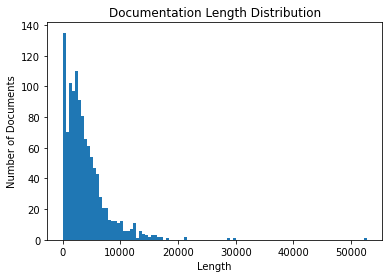

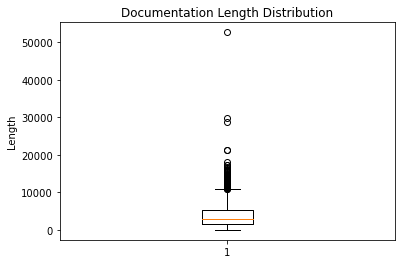

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np


github_docs = []
for doc_path in os.listdir('github_readme'):
    file_path = os.path.join('github_readme', doc_path)
    github_doc = open(file_path, 'r').read()
    github_docs.append(github_doc)


# length distribution
# draw a histogram


doc_lengths = [len(github_doc) for github_doc in github_docs]
print(doc_lengths[0:10])
plt.hist(doc_lengths, bins=100)
plt.title('Documentation Length Distribution')
plt.xlabel('Length')
plt.ylabel('Number of Documents')
plt.show()

# draw a boxplot
plt.boxplot(doc_lengths)
plt.title('Documentation Length Distribution')
plt.ylabel('Length')
plt.show()

# To-Do: 我们可以对比一下EMSE那篇收集到的在Github上AI相关的repository的documentation的长度分布

In [7]:
# do statisitcally test. the github projects have longer documentation than the huggingface projects.
len(github_docs)

1149

In [8]:
# analyze what's inside the documentation
# We consider: lists, code blocks, inline code, images, tables, and external links.
# write regular expressions to match them

import re

# Assuming 'docs' is a list of strings representing the contents of readme files
list_count = 0

# This pattern matches a list marker that's either at the start of the document
# or is not directly after another list item
list_start_pattern = re.compile(r'(?:^|\n)(?!\s*[-*]\s*\n)\s*[-*]\s')

for doc in github_docs:
    # Normalize line endings to Unix style for consistency
    doc = doc.replace('\r\n', '\n').replace('\r', '\n')

    # Find all matches for list starts
    list_starts = list_start_pattern.findall(doc)

    list_count += len(list_starts)

print(f"Total number of lists: {list_count}")
# print average
print(f"Average number of lists: {list_count / len(github_docs)}")

Total number of lists: 6919
Average number of lists: 6.021758050478677


In [9]:
# Assuming 'docs' is a list of strings representing the contents of readme files
code_block_pattern = re.compile(r'```')  # Pattern to match the start or end of a code block
code_block_count = 0

for doc in github_docs:
    # Find all occurrences of the code block pattern and divide by 2 since each block has a start and end
    code_block_count += len(code_block_pattern.findall(doc)) // 2

print(f"Total number of code blocks: {code_block_count}")
# print average
print(f"Average number of code blocks: {code_block_count / len(github_docs)}")

Total number of code blocks: 4509
Average number of code blocks: 3.9242819843342036


In [10]:
# inline code
inline_code_pattern = re.compile(r'`')
inline_code_count = 0
for doc in github_docs:
    inline_code_count += len(inline_code_pattern.findall(doc)) 
print(f"Total number of inline code: {inline_code_count}")
# print average
print(f"Average number of inline code: {inline_code_count / len(github_docs)}")

Total number of inline code: 44395
Average number of inline code: 38.63794604003481


In [21]:
# Assuming 'docs' is a list of strings representing the contents of readme files
table_count = 0
table_pattern = re.compile(r'(\|.+?\|)')  # Look for a sequence of the '|' character surrounded by other text

for doc in github_docs:
    # Find all potential table rows
    potential_table_rows = table_pattern.findall(doc)
    # Filter out rows that are just bold syntax or other non-table uses of '|'
    table_rows = [row for row in potential_table_rows if row.count('|') > 1]
    # Now we need to find consecutive rows, since a Markdown table consists of at least two consecutive rows of cells
    current_table_lines = 0
    for i in range(1, len(table_rows)):
        if table_rows[i-1].count('|') == table_rows[i].count('|'):
            # We have a consecutive row, so we increment our current table line count
            current_table_lines += 1
        else:
            # If the line counts do not match, we're not in a table anymore
            if current_table_lines > 0:
                # We had a table, so we count it and reset the line count
                table_count += 1
                current_table_lines = 0
    # Check if the last line was part of a table
    if current_table_lines > 0:
        table_count += 1

print(f"Total number of tables: {table_count}")
# print average
print(f"Average number of tables: {table_count / len(github_docs)}")


Total number of tables: 155
Average number of tables: 0.13489991296779807


In [22]:

# Assuming 'docs' is a list of strings representing the contents of readme files
# This pattern is looking for Markdown image syntax with common image file extensions
image_pattern = re.compile(r'!\[.*?\]\((.*?\.(?:png|jpe?g|gif|bmp|svg))(?:\s*".*?")?\)', re.IGNORECASE)
image_count = 0

for doc in github_docs:
    # Find all matches for image syntax with a proper image file extension
    images = image_pattern.findall(doc)
    image_count += len(images)

print(f"Total number of images: {image_count}")
# print average
print(f"Average number of images: {image_count / len(github_docs)}")


Total number of images: 618
Average number of images: 0.5378590078328982


In [23]:
import re

# Assuming 'docs' is a list of strings representing the contents of readme files
# This pattern is a basic URL pattern and might need to be extended based on the actual contents
url_pattern = re.compile(r'https?://\S+')
url_count = 0

for doc in github_docs:
    # Find all matches for URLs
    urls = url_pattern.findall(doc)
    url_count += len(urls)

print(f"Total number of URLs: {url_count}")
# print average
print(f"Average number of URLs: {url_count / len(github_docs)}")


Total number of URLs: 9727
Average number of URLs: 8.46562228024369


## Raw Data
AGPL-3.0: 2
AI MODEL LICENSE written by AI2, apache-2.0 from pythia: 1
AI MODEL LICENSE written by AI2, gpl-3.0 from LLaMa: 6
AI MODEL LICENSE written by AI2, OPT model license written by Meta: 1
apache-2.0: 53
apache-2.0 and their own license: 1
bigcode-openrail-m: 32
bigscience-bloom-rail-1.0: 1
bsd-2-clause: 1
bsd-3-clause: 46
cc-by-4.0: 1
cc-by-nc-4.0: 4
cc-by-nc-sa-4.0: 2
cc-by-sa-4.0: 9
mit: 35
openrail: 13
other: 7
wtfpl: 1


## Combined
apache-2.0: 53 + 1 + 1 = 55
RAIL: 32+1+13 = 46
bsd-3-clause: 46
mit: 35
cc-by: 1 + 4 + 2 + 9 = 16
AI MODEL LICENSE written by AI2: 8
GPL3.0=3
bsd-2-clause: 1
Others: 8

我们还发现，会存在多个license的情况。列举出来.
可视化不一定要用图，可以是用表格


In [ ]:

# Count the license distribution

